In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
#!! unzip data.zip

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_np = seq_df.as_matrix().squeeze()
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def get_codones_set(df):
    s = set()
    maxlen = 0
    for i in range(df.shape[0]):
        if i % 10000 == 0:
            print(i, 'of', df.shape[0])
        for idx in range(len(df[i]) - 2):
            s.add(df[i][idx:idx+3])
    return s

def get_codones_number_nparr(seq_np, codones_dict):
    l = np.zeros(137373126, dtype=np.int32)
    idx = 0;
    nstr = 0;
    for s in seq_np:
        if nstr % 10000 == 0:
            print(nstr, 'of', seq_np.shape[0])
        for i in range(len(s) - 2):
            l[idx] = codones_dict[s[i:i+3]]
            idx += 1
        nstr += 1
    print("result size:", idx)
    return l


In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
codones_set = read_or_create(read_path='data/codones_set.pickle',
                             producer= lambda: get_codones_set(seq_np))
print(len(codones_set))

reading data/codones_set.pickle
9424


In [7]:
codones_dict = read_or_create(read_path='data/codones_dict.pickle',
                             producer=lambda: {cod: i for i, cod in enumerate(codones_set)})

reading data/codones_dict.pickle


In [8]:
codones_num_arr = read_or_create(read_path='data/codones_num_arr.pickle',
                             producer=lambda: get_codones_number_nparr(codones_dict=codones_dict, seq_np=seq_np))
print(codones_num_arr.shape)

reading data/codones_num_arr.pickle
(137373126,)


In [16]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    for i in range(3):
        yield make_codones(seq[i:]) 

def create_all_codones(df):
    for row in df:
        yield from seq_to3(row)

In [10]:
######################

In [55]:
def generate_sample(index_words_list, context_window_size, nneg):
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            pos_samp = index_words[max(0, index - context_window_size):index] + \
                index_words[index + 1: index + context_window_size + 1]
            for pos in pos_samp:
                #neg_samp = np.random.choice(codones_num_arr, nneg)
                neg_samp = np.zeros(nneg)
                for i in range(nneg):
                    samp = center
                    while samp in pos_samp:
                        samp = np.random.choice(codones_num_arr, 1)[0]
                    neg_samp[i] = center
                yield center, pos, neg_samp


def get_batch(iterator, batch_size, nneg):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros([batch_size], dtype=np.int32)
        pos_batch = np.zeros([batch_size], dtype=np.int32)
        neg_batch = np.zeros([batch_size, nneg], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], pos_batch[index], neg_batch[index] = next(iterator)
        yield center_batch, pos_batch, neg_batch


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def process_data(all_codones, dictionary, batch_size, skip_window, nneg):
    cod_dicts = (cod_to_dict(cod, dictionary) for cod in all_codones)
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window, nneg=nneg)
    batch_gen = get_batch(single_gen, batch_size=batch_size, nneg=nneg)
    return batch_gen

In [12]:
######################

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        self.uemb = nn.Embedding(vocab_size, embed_size, sparse=True)
        self.vemb = nn.Embedding(vocab_size, embed_size, sparse=True)
        
        initrange = 0.5 / self.embed_size
        self.uemb.weight.data.uniform_(-initrange, initrange)
        self.vemb.weight.data.uniform_(-0, 0)
    
    def forward(self, cent, pos, neg, batch_size):

        emb_cent = self.uemb(cent)
        emb_pos = self.vemb(pos)

        pos_score  = torch.bmm(emb_cent.unsqueeze(1), emb_pos.unsqueeze(2)).squeeze()

        log_pos = F.logsigmoid(pos_score)

    
        emb_neg = self.vemb(neg)
        
        neg_score = torch.bmm(emb_neg, emb_cent.unsqueeze(2)).squeeze()
        log_neg = F.logsigmoid(-1*neg_score)
        
        log_neg = log_neg.sum(dim=1).squeeze()

        loss = log_pos + log_neg

        return -1 * loss.sum()

In [56]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 0.01
NUM_TRAIN_STEPS = 100000
#SKIP_STEP = 2000
BATCH_SIZE = 128

SKIP_WINDOW = 12  # the context window

def training():
    batch_gen = process_data(create_all_codones(seq_np), codones_dict,\
                             batch_size=BATCH_SIZE, skip_window=SKIP_WINDOW, nneg=5)

    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    batchcount = 0
    printcount = 0

    for center, positive, negative in batch_gen:

        center = torch.LongTensor(center)
        positive = torch.LongTensor(positive)
        negative = torch.LongTensor(negative)

        #print('shapes', center.shape, positive.shape, negative.shape)
        optimizer.zero_grad()

        loss = model(center, positive, negative, BATCH_SIZE)

        loss.backward()
        optimizer.step()

        if batchcount % 1000 == 0:
            print(batchcount, 'of', NUM_TRAIN_STEPS, 'loss:', loss.item())
        if batchcount > NUM_TRAIN_STEPS:
            break
        batchcount += 1

    return model.uemb

In [16]:
######################

In [57]:
embed = read_or_create(read_path='data/final_emb_matrix.pickle',
                             producer=lambda: training())

0 of 100000 loss: 532.3369750976562
1000 of 100000 loss: 532.168212890625
2000 of 100000 loss: 279.96771240234375
3000 of 100000 loss: 527.6865234375
4000 of 100000 loss: 79.16529083251953
5000 of 100000 loss: 427.5097961425781
6000 of 100000 loss: 386.9910888671875
7000 of 100000 loss: 216.375732421875
8000 of 100000 loss: 179.2954559326172
9000 of 100000 loss: 183.99061584472656
10000 of 100000 loss: 76.45868682861328
11000 of 100000 loss: 345.0237731933594
12000 of 100000 loss: 193.6202392578125
13000 of 100000 loss: 198.71873474121094
14000 of 100000 loss: 134.63296508789062
15000 of 100000 loss: 91.93449401855469
16000 of 100000 loss: 73.12174987792969
17000 of 100000 loss: 174.98910522460938
18000 of 100000 loss: 103.3394775390625
19000 of 100000 loss: 87.89686584472656
20000 of 100000 loss: 186.8085479736328
21000 of 100000 loss: 173.1754150390625
22000 of 100000 loss: 72.63814544677734
23000 of 100000 loss: 60.88004684448242
24000 of 100000 loss: 44.29595947265625
25000 of 1000

In [11]:
######################

In [59]:
final_embed_matrix = embed.weight.data.numpy()
print(final_embed_matrix.shape)

(9424, 100)


In [60]:
tsne = TSNE(n_components=2, random_state=42)

#XX = tsne.fit_transform(final_embed_matrix)

XX = read_or_create(read_path='data/XX.pickle',
                             producer=lambda: tsne.fit_transform(final_embed_matrix))

saving data/XX.pickle


In [61]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(codones_dict, key=codones_dict.get)
tsne_df['codone'] = list(codones_set)
tsne_df.head()

,x0,x1,codone
0,14.103257,30.518980,HCE
1,14.989849,18.349056,RGN
2,17.015549,14.081740,XVT
3,26.377045,-33.997208,CVP
4,3.803391,31.784826,TLF


In [62]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

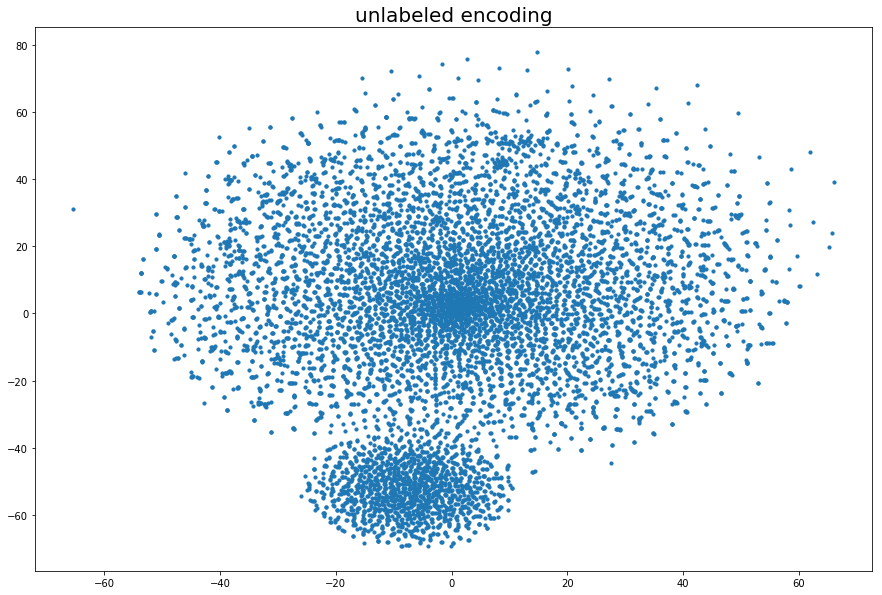

In [63]:
plot_tsne_df(tsne_df)

In [64]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [ ]:
######################

In [65]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [66]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [67]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,AEE,-1.733333,109.768633,17.000000,121.800000
1,DTI,0.100000,109.782967,18.333333,131.300000
2,LRN,-1.400000,127.815300,21.666667,151.400000
3,FEE,-1.400000,135.133967,20.333333,155.566667
4,VVK,1.500000,108.811500,20.666667,149.533333


In [68]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,AEE,-1.733333,109.768633,17.000000,121.800000,-15.664921,-53.670387
1,DTI,0.100000,109.782967,18.333333,131.300000,34.075932,29.246023
2,LRN,-1.400000,127.815300,21.666667,151.400000,-31.445047,55.547073
3,FEE,-1.400000,135.133967,20.333333,155.566667,21.072857,-13.015167
4,VVK,1.500000,108.811500,20.666667,149.533333,43.318199,23.946989


In [69]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

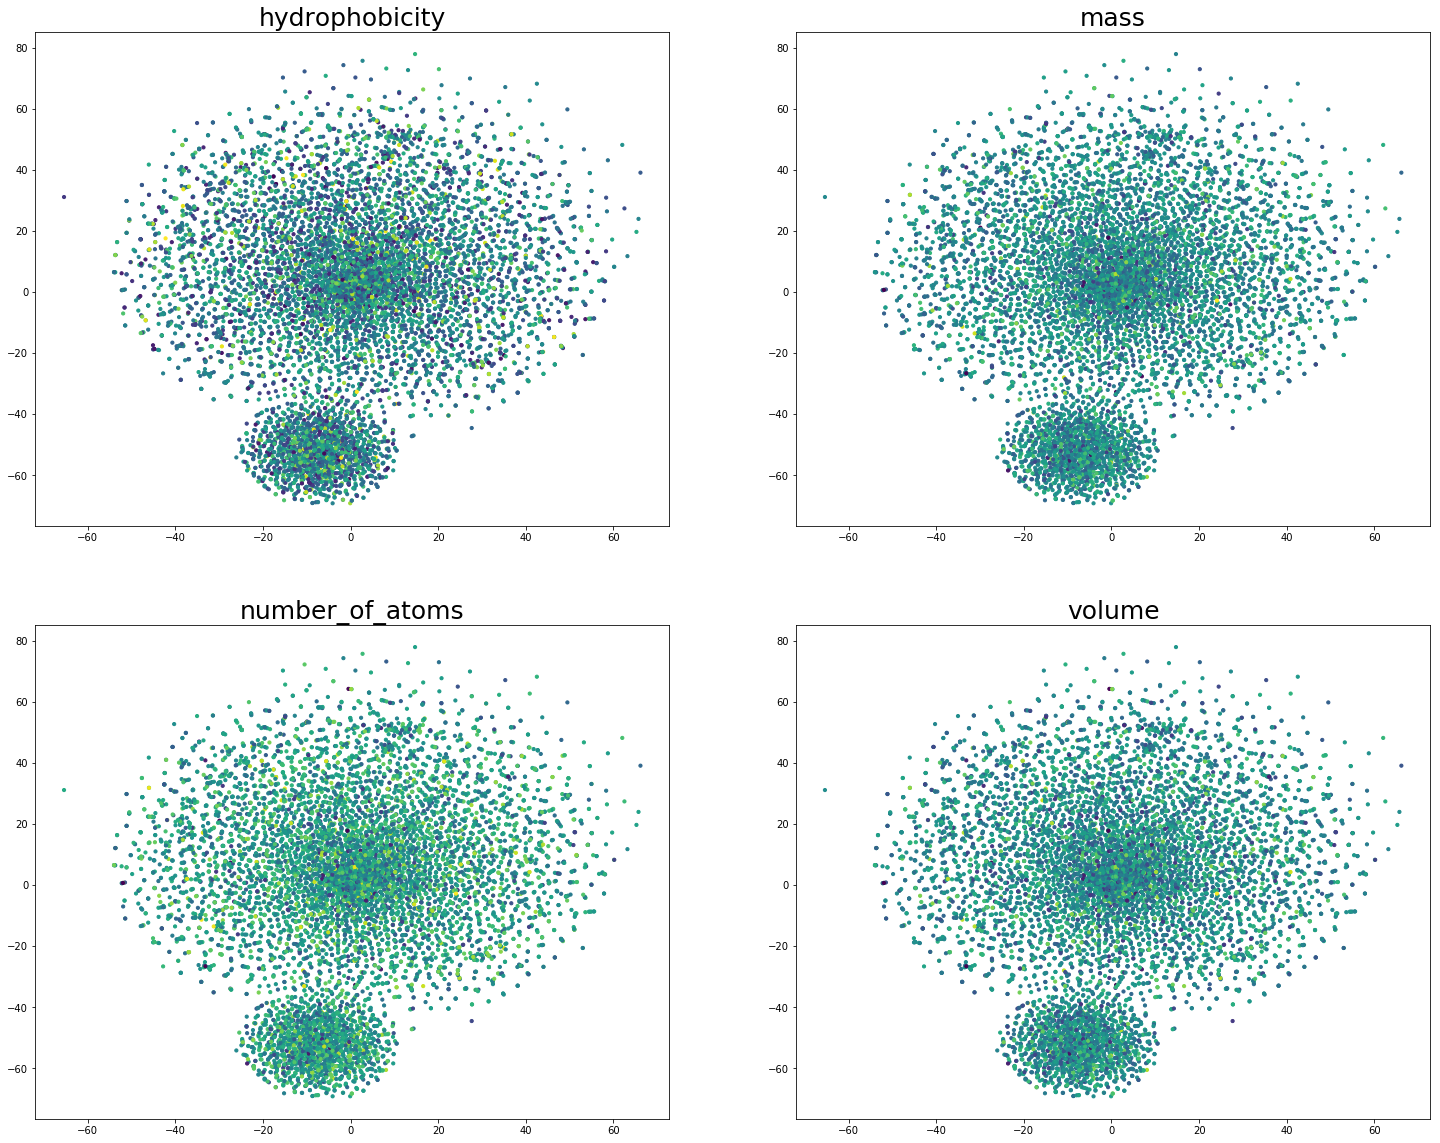

In [70]:
plot_embedding_properties(final_df)

In [28]:
######################

In [71]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

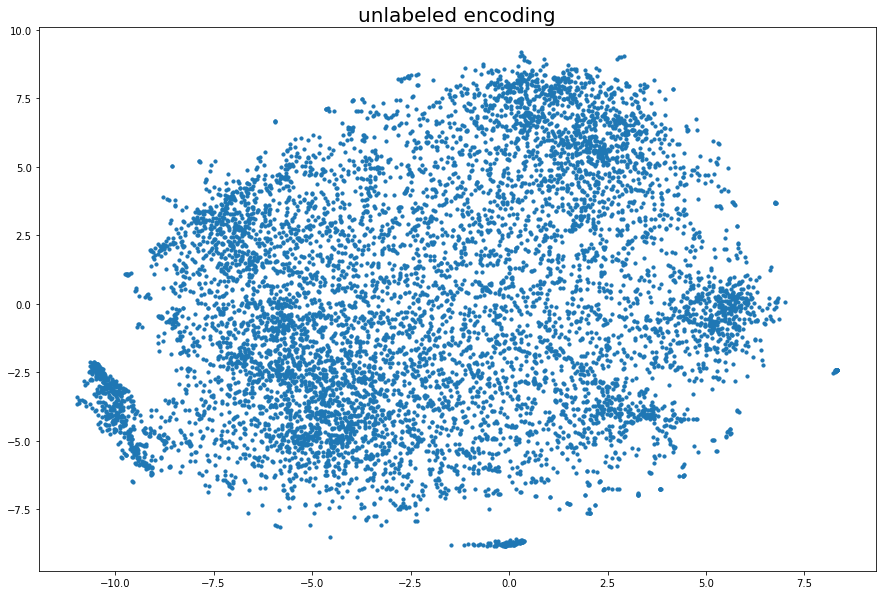

In [72]:
plot_tsne_df(gensim_tsne_df)

In [73]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

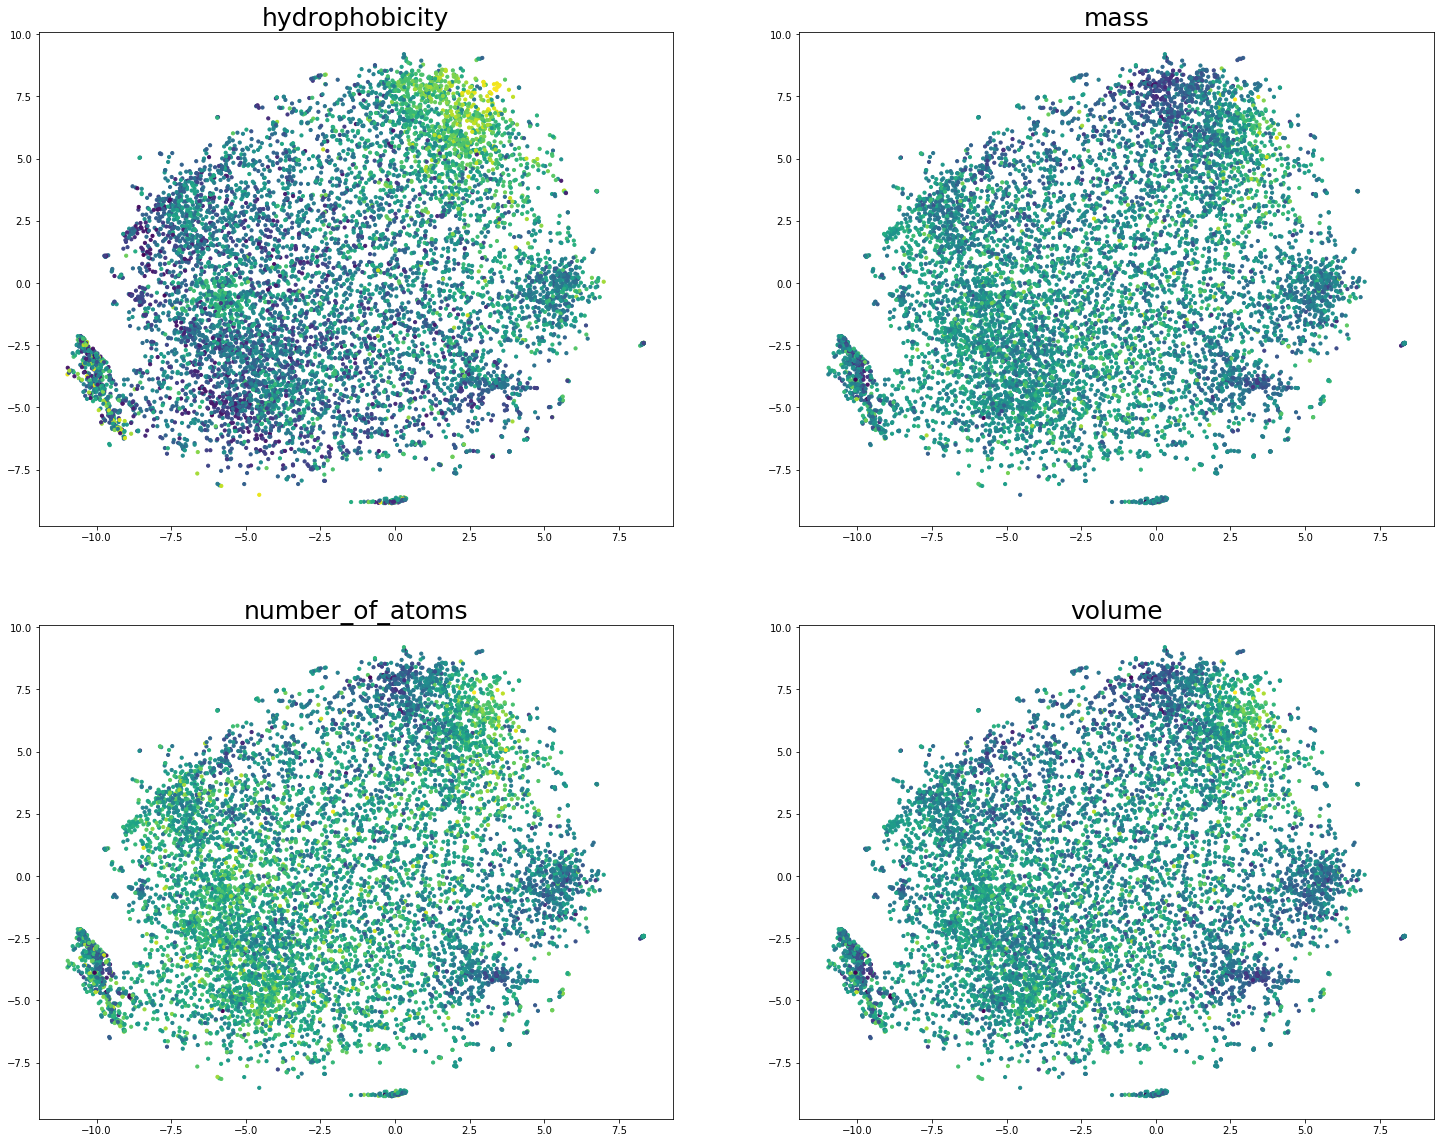

In [74]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [ ]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59